In [1]:
import h5py, numpy, astropy.time, pylab
from pycbc.events.veto import start_end_to_segments, indices_within_times

In [2]:
f = h5py.File('./summO3.hdf', 'r')

In [4]:
#check the hdf5 file with h5ls -r is the most convenient way

In [5]:
bins = numpy.arange(2.0, 30.0, .1)
ifos = ['H1', 'L1', 'V1']
types = [ 'H1L1V1', 'H1L1', 'H1V1', 'L1V1']

In [6]:
# get the population prior
from scipy.interpolate import interp1d
from pycbc.conversions import mchirp_from_mass1_mass2

pop = h5py.File('./simplepopprior.hdf', 'r')
popmc = pop['mchirp'][:]
popprior = pop['prior'][:]
popp = interp1d(popmc, popprior, bounds_error=False)

def reweight_pop(stat, template):
    b = h5py.File('./bbh2.hdf', 'r')
    m1 = b['mass1'][:][template]
    m2 = b['mass2'][:][template]
    mc = mchirp_from_mass1_mass2(m1, m2)
    
    popt = numpy.log(popp(mc))
    #popt = 0
    return(stat + popt)

def reweight_pop2(stat, mc):
    popt = numpy.log(popp(mc))
    #popt = 0
    return(stat + popt)

In [2]:
# prepoulate some segment info
tstart = {}
tend = {}
for t in types:
    tstart[t] = []
    tend[t] = []

segs = {}
for chunk in f.keys():
    chunk = str(chunk)
    
    csegs = {}
    for t in types:
        if t in f[chunk]['background']:
            s = f[chunk]['background'][t]['start'][:]
            e = f[chunk]['background'][t]['end'][:]
            csegs[t] = s, e
            
        tstart[t].append(s)
        tend[t].append(e)
        
    segs[chunk] = csegs
    
for t in types:
    tstart[t] = numpy.concatenate(tstart[t])
    tend[t] = numpy.concatenate(tend[t])
    
def get_on(time):
    for t in types:
        x = indices_within_times(numpy.array([time]), tstart[t], tend[t])
        if len(x) != 0:
            return t

84.58421052631577 1.0
95.54872717387173 1.1296284091242381
11.30154212445153 0.13361290545988366
18.49222579748303 0.21862503276222858
{'H1L1V1': 2492383.5986011256, 'H1L1': 2815467.319415133, 'H1V1': 333014.6141296568, 'L1V1': 544897.4459002123}


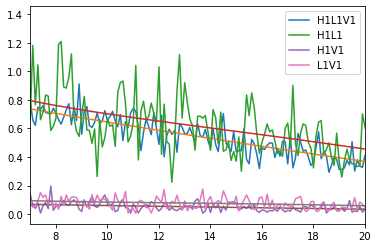

In [3]:
########## Calculate the expected foreground rates ###################
from pycbc.pnutils import chirp_distance

fac = 365.25 / 95.0
count = 22
nexpect = count * fac
nthresh = 20

stats = []
dists = []
times = []
ifars = []
mchirps = []
for chunk in f.keys():
    chunk = str(chunk)

    #stat = f[chunk]['inj/stat'][:]
    dist = f[chunk]['inj/dist'][:]
    time = f[chunk]['inj/time'][:]
    ifar = f[chunk]['inj/ifar_exc'][:]
    mc = f[chunk]['inj/mchirp'][:]
    stat = reweight_pop2(f[chunk]['inj/stat'][:], mc)
    stats.append(stat)
    dists.append(dist)
    times.append(time)
    ifars.append(ifar)
    mchirps.append(mc)

stats = numpy.concatenate(stats)
dists = numpy.concatenate(dists)
times = numpy.concatenate(times)
ifars = numpy.concatenate(ifars)
mchirps = numpy.concatenate(mchirps)

cdist = chirp_distance(dists, mchirps)
#pylab.hist(cdist)

which = {}
vave = {}
sig = {}

for t in types:
    x = indices_within_times(times, tstart[t], tend[t])
    
    if 'H1L1V1' in which:
        keep = ~numpy.isin(x, which['H1L1V1'])
        which[t] = x[keep]
    else:
        which[t] = x
    
    w = cdist[which[t]] ** 2.0
    l = ifars[which[t]] > 10.0
    d = cdist[which[t]]
    dave = (w[l] * d[l]).sum() / w[l].sum()
    vave[t] = dave ** 3.0
    
    nw = nexpect / w[stats[which[t]] > nthresh].sum()
    
    nr = vave[t] / vave['H1L1V1']
    
    c, _ = numpy.histogram(stats[which[t]], weights=nw * w * nr, bins=bins)
    
    l =  numpy.searchsorted(bins, nthresh)
    v = (w * nr * nw)[stats[which[t]] > nthresh].sum()
    print(v, nr)
    
    pylab.plot(bins[:-1], c, label=t)
    
    cv = (bins[:-1] + bins[1:]) / 2.0
    p = numpy.polyfit(cv, c, 4)
    
    ybin = numpy.polyval(p, bins)
    pylab.plot(bins, ybin)
    
    pylab.xlim(7, 20)
    sig[t] = ybin
    
print(vave)
pylab.legend()

In [4]:
########## Calculate the expected background rates ###################

import pylab

def get_back(chunk, active):
    chunk = str(chunk)    
    stat = reweight_pop(f[chunk]['background/stat'][:], f[chunk]['background/tid'][:])
    dec = f[chunk]['background/dec'][:]
    
    tid = {}
    for ifo in ifos:
        if ifo in f[chunk]['background']:
            tid[ifo] = f[chunk]['background'][ifo]['trig'][:]

    on = {ifo: tid[ifo] != -1 for ifo in tid}

    keep = None
    for j in range(len(active) // 2):
        ifo = active[j*2:j*2 + 2]
        
        if keep is None:
            keep = on[ifo]
        else:
            keep = keep & on[ifo]
            
    stat = stat[keep]
    dec = dec[keep]
    
    btime = f[chunk]['background'][active].attrs['background_time_exc'] / 365.25 / 86400.
    w = dec / btime
    
    le = bins[:-1]
    re = bins[1:]
    
    c, _ = numpy.histogram(stat, weights=w, bins=bins)
    pylab.plot(bins[:-1], c)
    pylab.yscale('log')
    pylab.xlim(10, 20)
    return c

1252627040.69 2019-09-15 23:57:39.693359 40.21 H1L1V1 1.00
1252699636.90 2019-09-16 20:07:35.901367 8.26 H1L1V1 0.90
1242984073.79 2019-05-27 09:21:32.792969 8.70 H1L1 0.94
1240292407.21 2019-04-26 05:40:26.212646 4.53 H1L1V1 0.40
1240423628.68 2019-04-27 18:07:27.675537 5.13 H1L1V1 0.53
1248242631.99 2019-07-27 06:04:10.986816 33.78 H1L1V1 1.00
1248331528.53 2019-07-28 06:45:47.531982 43.88 H1L1V1 1.00
1248112066.46 2019-07-25 17:48:05.464600 9.15 H1L1V1 0.96
1238782700.29 2019-04-08 18:18:39.286133 57.54 H1L1V1 1.00
1239082262.17 2019-04-12 05:31:21.166504 71.02 H1L1V1 1.00
1239198206.74 2019-04-13 13:43:45.735840 13.67 H1L1V1 1.00
1239168612.50 2019-04-13 05:30:31.499512 11.29 H1L1V1 1.00
1242459857.46 2019-05-21 07:44:36.462402 122.82 H1L1 1.00
1242315362.39 2019-05-19 15:36:21.389404 47.79 H1L1V1 1.00
1242442967.44 2019-05-21 03:03:06.442383 22.34 H1L1V1 1.00
1241816086.74 2019-05-13 20:55:05.742350 25.27 H1L1V1 1.00
1242107479.83 2019-05-17 05:51:38.826660 14.47 H1L1V1 1.00
12418

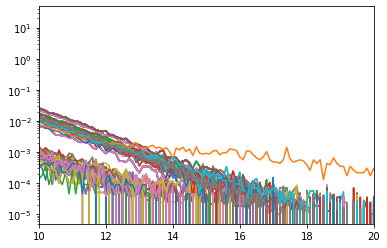

In [5]:
num = 0
for chunk in f.keys():
    chunk = str(chunk)
    
    for i, stat in enumerate(f[chunk]['stat'][:]):
        # get event time
        times = {}
        
        stat = reweight_pop(stat, f[chunk]['tid'][i])
        if stat < 2.0:
            continue
        for ifo in ifos:
            if ifo in f[chunk]:
                times[ifo] = f[chunk][ifo]['time'][i]
        used = [k for k in times if times[k] != -1]
        used = ''.join(used)
        atime = numpy.mean([times[k] for k in times if times[k] != - 1])
        
        # determine which detectors were actually on at this time
        on = get_on(atime)
        
        # get the background and calculate the expectation for 1 year 
        if len(on) == 6:
            bnum = get_back(chunk, 'H1L1')
            #bnum += get_back(chunk, 'H1V1')
            #bnum += get_back(chunk, 'L1V1')
            bnum += get_back(chunk, 'H1L1V1')
        else:
            bnum = get_back(chunk, on) 
            
        # get the expected foreground counts for this type per year
        fnum = sig[on]   
        #print(fnum.sum(), bnum.sum())
        
        bnum[bnum == 0] = bnum[bnum != 0].min()         # limit in case of zero values
        
        
        #calculate pastro
        if (bins > stat).sum() == 0:
            fn = 100000
            bn = 1
        else:
            l = numpy.searchsorted(bins, stat) - 1
            fn = fnum[l]
            bn = bnum[l]
        
        pastro = fn / (fn + bn)
    
        min_pastro = fnum[0] / (fnum[0] + bnum[0])
    

        ta = astropy.time.Time(atime, format='gps').datetime
        if pastro > 0.2:
            print('%2.2f %s %2.2f %s %2.2f' % (atime, ta, stat, on, pastro))
            num += 1      

7.5000000000000036
8.100000000000005
8.100000000000005
7.5000000000000036
7.5000000000000036
7.5000000000000036
7.700000000000005
7.700000000000005
7.700000000000005
9.400000000000006
9.400000000000006
7.800000000000004
10.600000000000007
7.900000000000004
10.600000000000007
10.600000000000007
7.600000000000004
6.400000000000003
7.800000000000004
6.400000000000003
7.800000000000004
7.600000000000004
7.300000000000004
7.300000000000004
7.400000000000004
5.200000000000002
7.400000000000004
7.700000000000005
6.700000000000003
7.700000000000005
7.600000000000004
8.300000000000004
8.300000000000004
8.200000000000005
8.200000000000005
8.400000000000006
8.300000000000004
8.300000000000004
8.100000000000005
8.100000000000005
8.100000000000005
8.100000000000005
7.900000000000004
8.100000000000005
8.100000000000005
11.700000000000008
8.100000000000005
8.100000000000005
7.900000000000004
8.900000000000006
7.900000000000004
8.900000000000006
7.900000000000004
7.700000000000005
7.800000000000004
7.

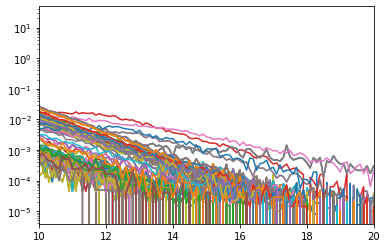

In [6]:
cstart = numpy.zeros(len(f.keys()))
cend = numpy.zeros(len(f.keys()))
for k in f.keys():
    s = numpy.inf
    e = -numpy.inf
    for t in types:
        try:
            s = min(s, f[k]['background'][t]['start'][:].min())
            e = max(e, f[k]['background'][t]['end'][:].max())
        except:
            pass
    cstart[int(k)] = s
    cend[int(k)] = e


def get_chunk(time):
    x = numpy.where((time > cstart) & (time < cend))[0]
    if len(x) == 1:
        return x[0]
    else:
        return -1


ptarget = 0.9
atime = 1170079035.73
times = numpy.arange(cstart.min()+1, cend.max()-1, 100000)

for atime in times:
    stats = numpy.arange(3, 12, .1)
    chunk = get_chunk(atime)

    # determine which detectors were actually on at this time
    on = get_on(atime)

    if on is None:
        continue
    
    # get the background and calculate the expectation for 1 year 
    if len(on) == 6:
        bnum = get_back(chunk, 'H1L1')
        bnum += get_back(chunk, 'H1L1V1')
    else:
        bnum = get_back(chunk, on) 

    # get the expected foreground counts for this type per year
    fnum = sig[on]   
    #print(fnum.sum(), bnum.sum())

    bnum[bnum == 0] = bnum[bnum != 0].min()         # limit in case of zero values


    #calculate pastro
    for stat in stats:
        if (bins > stat).sum() == 0:
            fn = 100000
            bn = 1
        else:
            l = numpy.searchsorted(bins, stat) - 1
            fn = fnum[l]
            bn = bnum[l]

        pastro = fn / (fn + bn)
        if pastro > ptarget:
            stat_threshold = stat
            break
        
    print(stat_threshold)